In [1]:
import findspark
findspark.init()

from pyspark import SparkContext, SparkConf 
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, DoubleType, ArrayType
import sys
import numpy as np
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from pyspark.sql.functions import when
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import GBTRegressor, RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

spark = SparkSession.builder.appName("House").getOrCreate()

In [2]:
schema = StructType([
    StructField("pid", StringType(), True),
    StructField("legal_type", StringType(), True),
    StructField("folio", StringType(), True),
    StructField("land_coordinate", StringType(), True),
    StructField("zoning_district", StringType(), True),
    StructField("zoning_classification", StringType(), True),
    StructField("lot", StringType(), True),
    StructField("plan", StringType(), True),
    StructField("block", StringType(), True),
    StructField("district_lot", StringType(), True),
    StructField("from_civic_number", StringType(), True),
    StructField("to_civic_number", StringType(), True),
    StructField("street_name", StringType(), True),
    StructField("property_postal_code", StringType(), True),
    StructField("narrative_legal_line1", StringType(), True),
    StructField("narrative_legal_line2", StringType(), True),
    StructField("narrative_legal_line3", StringType(), True),
    StructField("narrative_legal_line4", StringType(), True),
    StructField("narrative_legal_line5", StringType(), True),
    StructField("current_land_value", IntegerType(), True),
    StructField("current_improvement_value", IntegerType(), True),
    StructField("tax_assessment_year", StringType(), True),
    StructField("previous_land_value", IntegerType(), True),
    StructField("previous_improvement_value", IntegerType(), True),
    StructField("year_built", StringType(), True),
    StructField("big_improvement_year", StringType(), True),
    StructField("tax_levy", DoubleType(), True),
    StructField("neighbourhood_code", StringType(), True),
    StructField("report_year", StringType(), True)
]);

In [3]:
input_df = spark.read.csv("housing_data.csv", header=True, schema=schema)

### Transforming and Filtering the data based on data quality checks.

In [4]:
# dropping columns that are not required for Analytics of data

df_dropped = input_df.drop( 'lot', 'plan' , 'block', 'district_lot', 'narrative_legal_line1', 'narrative_legal_line2', 
                   'narrative_legal_line3', 'narrative_legal_line4', 'narrative_legal_line5')

# removing records that have null value in key columns 

null_check_column_list = ['pid', 'legal_type', 'folio', 'land_coordinate', 'zoning_district', 'zoning_classification', 
                           'street_name', 'property_postal_code', 'current_land_value', 'current_improvement_value', 
                           'tax_assessment_year', 'year_built', 'neighbourhood_code', 'report_year']

dq_null_check_df = df_dropped.na.drop(subset=null_check_column_list)

### Cleaning data and removing invalid records

In [5]:
# we are only retaining records of properties that were built after 1990s to focus our analytics on latest trends

house_df = dq_null_check_df.filter(dq_null_check_df['year_built'] >= '1990')

# Removing invalid records

house_df = house_df.filter((house_df['big_improvement_year'] >= house_df['year_built']) | (house_df['big_improvement_year'].isNull()))

In [6]:
house_df.count()

478528

### Preprocessing Additional dataset for Analysis

In [7]:
mapping_df = spark.read.csv("neighbour_code_area_mapping.csv", header=True)
joined_df = house_df.join(mapping_df, house_df['neighbourhood_code'] == mapping_df['code'], 'inner' ).drop(mapping_df['code'])
joined_df = joined_df.withColumnRenamed(" NEIGHBOURHOOD_NAME", "neighbourhood")

In [8]:
avg_income = spark.read.csv("average_income.csv", header=True, inferSchema=True)
avg_income.createOrReplaceTempView("income")
avg_income_df = spark.sql("""
    SELECT area_name, 
    (sum(`Less_Than_$20000`) * 10000 +
sum(`$20000_to_$39999`) * 30000 +
sum(`$40000_to_$59999`) * 50000 +
sum(`$60000_to_$79999`) * 70000 +
sum(`$80000_to_$99999`) * 90000 +
sum(`$100000_And_Over`) * 110000)/sum(Total)
       
             AS Average_Income
    FROM income
    group by 1
""")
avg_income_df.show()

+--------------------+------------------+
|           area_name|    Average_Income|
+--------------------+------------------+
|            Oakridge| 70814.54820988823|
|         Shaughnessy| 72789.37766065275|
|            Fairview| 70814.54820988823|
|    Hastings-Sunrise| 57005.00922752439|
|      Mount Pleasant|  68342.3749246534|
|   Dunbar-Southlands| 72789.37766065275|
| Renfrew-Collingwood| 57460.72684642438|
| Victoria-Fraserview| 66594.23004870738|
|          Riley Park|  68342.3749246534|
|              Sunset|56043.956043956045|
|  Grandview-Woodland| 67399.77307110438|
|             Marpole|60060.180541624875|
|Kensington-Cedar ...| 68955.52789408171|
|            Downtown| 63822.47751165059|
|            West End|  58633.6464560205|
|           Killarney| 67399.77307110438|
|        South Cambie| 70814.54820988823|
|           Kitsilano| 70485.82995951417|
|       Arbutus-Ridge|60060.180541624875|
|     West Point Grey|53801.996672212976|
+--------------------+------------

In [9]:
final_df = joined_df.join(avg_income_df, joined_df['neighbourhood'] == avg_income_df['area_name'], 'inner' )\
    .drop(avg_income_df['area_name'])


In [10]:
transformed_df = final_df
transformed_df = (transformed_df
    .withColumn("tax_assessment_year", col("tax_assessment_year").cast("int"))
    .withColumn("year_built", col("year_built").cast("int"))
    .withColumn("neighbourhood_code", col("neighbourhood_code").cast("int"))
    .withColumn("report_year", col("report_year").cast("int"))
    .withColumn("big_improvement_year", col("big_improvement_year").cast("int"))
)
transformed_df = transformed_df.fillna(0)

In [11]:
final_df.createOrReplaceTempView("housing")

## Data Analytics 

### Metric 1 - Property Value Appreciation Rate

In [12]:
appreciation_df = spark.sql("""
    SELECT report_year, neighbourhood,
          avg (((current_land_value + current_improvement_value) - (previous_land_value + previous_improvement_value)) /
           (previous_land_value + previous_improvement_value)) * 100 AS appreciation_rate
    FROM housing
    WHERE previous_land_value IS NOT NULL AND previous_improvement_value IS NOT NULL and report_year not in ('2020')
    group by report_year, neighbourhood
    order by report_year desc , appreciation_rate desc 
""")
appreciation_df.show(10)

+-----------+--------------------+-----------------+
|report_year|       neighbourhood|appreciation_rate|
+-----------+--------------------+-----------------+
|       2023|           Killarney|8.772023911532266|
|       2023|    Hastings-Sunrise| 8.16941535647389|
|       2023|Kensington-Cedar ...|7.787482694436866|
|       2023| Renfrew-Collingwood|7.603353530063277|
|       2023| Victoria-Fraserview|7.449020355552995|
|       2023|  Grandview-Woodland|7.346334906898301|
|       2023|      Mount Pleasant|7.188699333372803|
|       2023|              Sunset|6.871441793138916|
|       2023|          Riley Park|6.714037997836396|
|       2023|            Fairview|6.467243883128955|
+-----------+--------------------+-----------------+
only showing top 10 rows



### Metric 2 - Tax Burden Percentage

In [13]:
tax_burden_df = spark.sql("""
    SELECT  ZONING_CLASSIFICATION, 
           (SUM(tax_levy) / (SUM(current_land_value) + SUM(current_improvement_value))) * 100 AS tax_burden_percentage
    FROM housing 
    where tax_levy is not null and report_year = '2023' and tax_assessment_year = '2023'
    GROUP BY  ZONING_CLASSIFICATION
""")
tax_burden_df.show(10)

+---------------------+---------------------+
|ZONING_CLASSIFICATION|tax_burden_percentage|
+---------------------+---------------------+
|      Historical Area|  0.42889387970159903|
|  Limited Agriculture|  0.41490953208423353|
|          Residential|   0.3207293255525528|
|           Industrial|   0.7443737844711653|
| Residential Inclu...|   0.3741981975433632|
| Comprehensive Dev...|   0.3799143420637402|
|           Commercial|  0.46800056265935924|
+---------------------+---------------------+



### Metric 3 -  Impact of Property Age on it's Value

In [14]:
age_of_properties_df = spark.sql("""
    SELECT  
          case when YEAR(CURRENT_DATE()) - CAST(Coalesce(big_improvement_year, year_built) AS INT) < 10 then "2023 to 2014"
           when YEAR(CURRENT_DATE()) - CAST(Coalesce(big_improvement_year, year_built) AS INT) < 20 then "2013 to 2004"
           when YEAR(CURRENT_DATE()) - CAST(Coalesce(big_improvement_year, year_built) AS INT) < 30 then "2003 to 1994"
           when YEAR(CURRENT_DATE()) - CAST(Coalesce(big_improvement_year, year_built) AS INT) < 40 then "1993 to 1990"
           end AS age_of_property, 
           avg( current_improvement_value) as avg_property_value
           
    FROM housing
    WHERE report_year = '2023' and ZONING_CLASSIFICATION like '%Residential'
    group by age_of_property
    order by avg_property_value desc
""")
age_of_properties_df.show(50)

+---------------+------------------+
|age_of_property|avg_property_value|
+---------------+------------------+
|   2023 to 2014| 430296.7072297781|
|   2013 to 2004|376290.71415607986|
|   2003 to 1994| 272131.8662113299|
|   1993 to 1990| 234059.0861854387|
+---------------+------------------+



### Metric 4 - Neighborhood wise Average Property Rate and Average Income

In [15]:
neighborhood_affordability_df = spark.sql("""
    SELECT neighbourhood,
           AVG(current_land_value + current_improvement_value) AS avg_property_value, avg(Average_Income) as avg_income
    FROM housing
    GROUP BY neighbourhood
""")
neighborhood_affordability_df.show(30)

+--------------------+------------------+------------------+
|       neighbourhood|avg_property_value|        avg_income|
+--------------------+------------------+------------------+
|            Oakridge|2119302.6862084125| 70814.54820988823|
|         Shaughnessy| 6467541.899352751| 72789.37766065286|
|            Fairview|1467980.7794030674| 70814.54820988844|
|      Mount Pleasant|1253039.5449723902|  68342.3749246579|
|    Hastings-Sunrise|2019695.1502933095| 57005.00922752337|
|   Dunbar-Southlands| 3126202.291637967| 72789.37766065377|
| Renfrew-Collingwood| 1086443.693985879|57460.726846426194|
| Victoria-Fraserview|1619121.4121279486| 66594.23004870805|
|          Riley Park|1749342.1660612833| 68342.37492465269|
|              Sunset|1779958.7009541118| 56043.95604395671|
|  Grandview-Woodland|1359741.9073243646| 67399.77307110406|
|             Marpole|1437154.8306850547| 60060.18054162551|
|Kensington-Cedar ...| 1252266.778771671| 68955.52789408118|
|            Downtown|13

### Metric 5 - Property Improvement Ratio Over the Decades 

In [16]:
improvement_value_ratio_df = spark.sql("""
    SELECT report_year, 
   
          case when YEAR(CURRENT_DATE()) - CAST(Coalesce(big_improvement_year, year_built) AS INT) < 10 then "2023 to 2014"
           when YEAR(CURRENT_DATE()) - CAST(Coalesce(big_improvement_year, year_built) AS INT) < 20 then "2013 to 2004"
           when YEAR(CURRENT_DATE()) - CAST(Coalesce(big_improvement_year, year_built) AS INT) < 30 then "2003 to 1994"
           when YEAR(CURRENT_DATE()) - CAST(Coalesce(big_improvement_year, year_built) AS INT) < 40 then "1993 to 1990"
           end AS age_of_property,   
           avg(current_improvement_value / current_land_value) AS improvement_value_ratio
          
    FROM housing where report_year = '2023'
     group by report_year, age_of_property 
     order by improvement_value_ratio desc
    
""")
improvement_value_ratio_df.show()

+-----------+---------------+-----------------------+
|report_year|age_of_property|improvement_value_ratio|
+-----------+---------------+-----------------------+
|       2023|   2023 to 2014|    0.48196101824395265|
|       2023|   2013 to 2004|     0.4169256960449634|
|       2023|   2003 to 1994|     0.3675606257650462|
|       2023|   1993 to 1990|     0.3241698486422925|
+-----------+---------------+-----------------------+



### Metric 6 - Price to Income Ratio

In [17]:
price_to_income_df = spark.sql("""
    SELECT neighbourhood,
           (AVG(current_land_value) + AVG(current_improvement_value)) / AVG(Average_Income) AS price_to_income_ratio
    FROM housing
    GROUP BY neighbourhood
""")
price_to_income_df.show()

+--------------------+---------------------+
|       neighbourhood|price_to_income_ratio|
+--------------------+---------------------+
|            Oakridge|   29.927504160966784|
|         Shaughnessy|    88.85282588215968|
|            Fairview|    20.72993214688166|
|      Mount Pleasant|   18.334738094100008|
|    Hastings-Sunrise|    35.43013460855916|
|   Dunbar-Southlands|    42.94860585582163|
| Renfrew-Collingwood|   18.907587035743372|
| Victoria-Fraserview|    24.31323871367982|
|          Riley Park|   25.596742401620215|
|              Sunset|   31.760047409180835|
|  Grandview-Woodland|     20.1742801995771|
|             Marpole|   23.928579929742558|
|Kensington-Cedar ...|   18.160498759362838|
|            Downtown|    20.69431117765842|
|            West End|    28.42906428132009|
|           Killarney|   24.148319891667498|
|        South Cambie|   31.152080061316845|
|           Kitsilano|   20.591284905493925|
|       Arbutus-Ridge|    47.72583585472014|
|     West

### Metric 7 Tax Burden with respect to average income, Neighbourhood wise

In [18]:
tax_income_df = spark.sql("""
    SELECT neighbourhood, avg(tax_levy) as avg_tax_paid, avg(Average_Income) as avg_income, 
           avg(tax_levy)/avg(Average_Income) as  percent_income_house_tax
    FROM housing 
    where tax_levy is not null and report_year = '2023' and tax_assessment_year = '2023'
    GROUP BY  neighbourhood
    order by percent_income_house_tax desc
""")
tax_income_df.show(10)

+-------------------+------------------+------------------+------------------------+
|      neighbourhood|      avg_tax_paid|        avg_income|percent_income_house_tax|
+-------------------+------------------+------------------+------------------------+
|        Shaughnessy| 34331.16989937107|  72789.3776606527|      0.4716508232756777|
|    West Point Grey|18260.327461773693| 53801.99667221307|      0.3393986950526046|
|         Kerrisdale| 17761.26414847162| 72789.37766065307|      0.2440090122940098|
|      Arbutus-Ridge| 12043.89324290999| 60060.18054162469|     0.20053042022680856|
|  Dunbar-Southlands|13196.496041778251| 72789.37766065284|      0.1812970032976635|
|   Hastings-Sunrise| 8680.650272284323| 57005.00922752434|     0.15227872760509883|
|           West End| 7475.679028456452|58633.646456020615|      0.1274981086851513|
|             Sunset| 6934.375024975027|56043.956043955994|     0.12373100534759374|
|          Killarney| 7238.002792323329| 67399.77307110418|     0

### Metric 8 - Property Improvement Ratio across neighbourhood over the year

In [19]:
improvement_neighbourhood_df = spark.sql("""
    SELECT neighbourhood, report_year,
           AVG(current_improvement_value)/AVG(current_land_value) * 100 as improvement_ratio
    FROM housing where report_year not in ('2020')
    GROUP BY neighbourhood, report_year
    order by report_year desc, neighbourhood
""")
improvement_neighbourhood_df.show(10)

+--------------------+-----------+------------------+
|       neighbourhood|report_year| improvement_ratio|
+--------------------+-----------+------------------+
|       Arbutus-Ridge|       2023| 36.32029558252616|
|            Downtown|       2023| 48.54455463256919|
|   Dunbar-Southlands|       2023| 40.39429700200651|
|            Fairview|       2023|45.923531015565715|
|  Grandview-Woodland|       2023|30.368202238078528|
|    Hastings-Sunrise|       2023| 34.48156444974856|
|Kensington-Cedar ...|       2023| 37.63965334498865|
|          Kerrisdale|       2023| 45.04805697962659|
|           Killarney|       2023|  34.9814336757447|
|           Kitsilano|       2023|30.499118788129653|
+--------------------+-----------+------------------+
only showing top 10 rows



## Data Visualization

### Graph 1 - Showing Change in Appreciation of Property over the year based on Neighbourhood

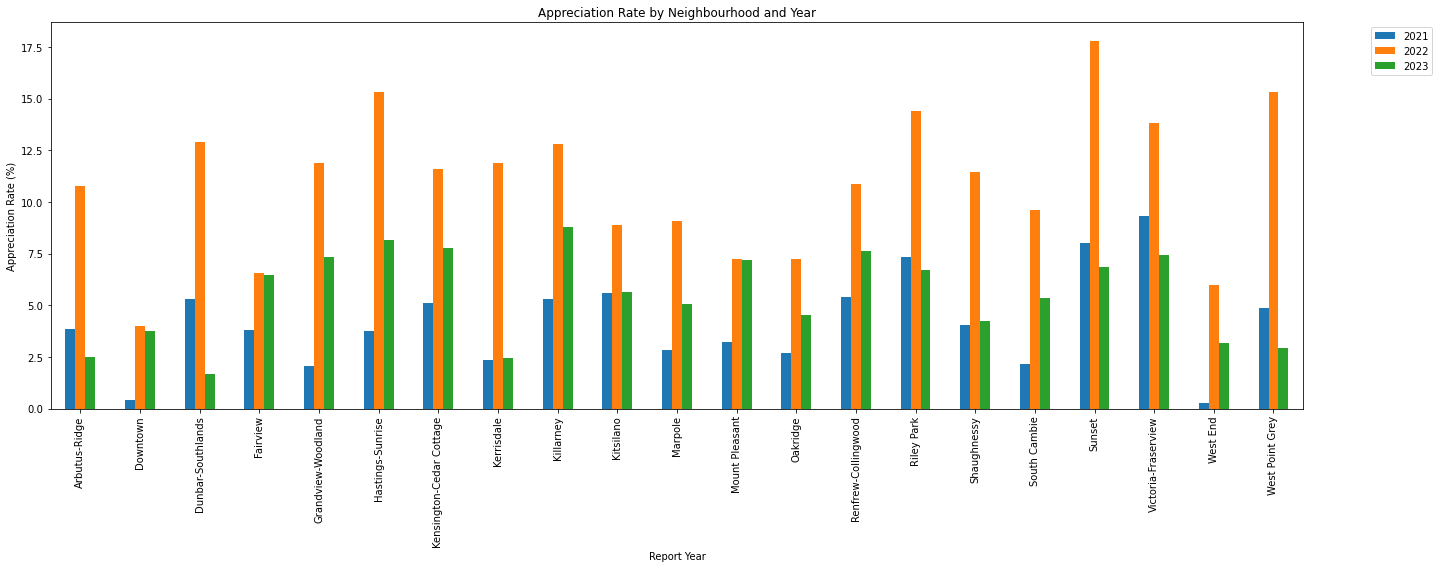

In [20]:
appreciation_pandas_df = appreciation_df.toPandas()
pivot_df = appreciation_pandas_df.pivot(index='neighbourhood', columns='report_year', values='appreciation_rate')
pivot_df.plot(kind='bar', figsize=(20, 8))
plt.xlabel('Report Year')
plt.ylabel('Appreciation Rate (%)')
plt.title('Appreciation Rate by Neighbourhood and Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Graph 2 - Showing Tax Burden with respect to zoning classifications

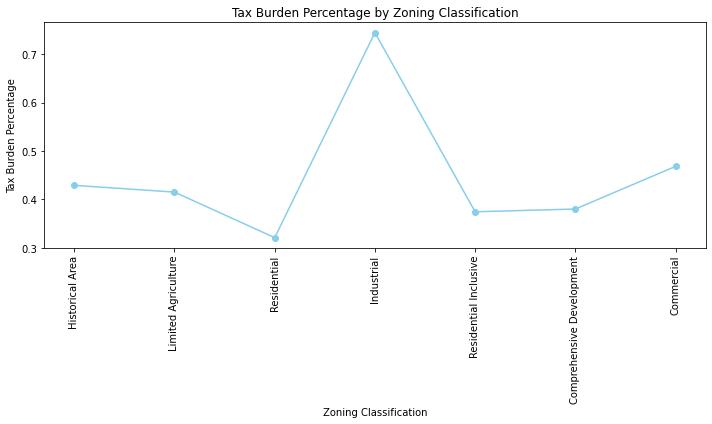

In [21]:
tax_burden_pandas_df = tax_burden_df.toPandas()
plt.figure(figsize=(10, 6))
plt.plot(tax_burden_pandas_df['ZONING_CLASSIFICATION'],
         tax_burden_pandas_df['tax_burden_percentage'],
         marker='o', linestyle='-', color='skyblue')
plt.xlabel('Zoning Classification')
plt.ylabel('Tax Burden Percentage')
plt.title('Tax Burden Percentage by Zoning Classification')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Graph 3 - Showing Percentage of Income used by Tax based on Neighbourhood

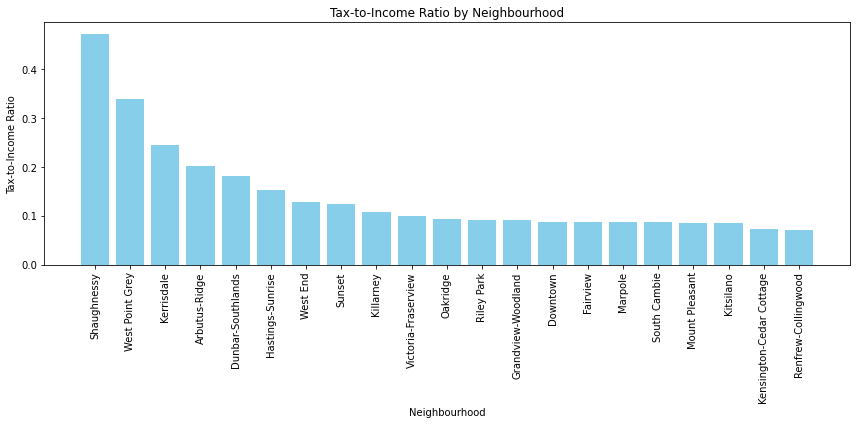

In [22]:
tax_income_pandas_df = tax_income_df.toPandas()
tax_income_pandas_df['tax_to_income_ratio'] = tax_income_pandas_df['avg_tax_paid'] / tax_income_pandas_df['avg_income']
plt.figure(figsize=(12, 6))
plt.bar(tax_income_pandas_df['neighbourhood'],
        tax_income_pandas_df['tax_to_income_ratio'],
        color='skyblue')
plt.xlabel('Neighbourhood')
plt.ylabel('Tax-to-Income Ratio')
plt.title('Tax-to-Income Ratio by Neighbourhood')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

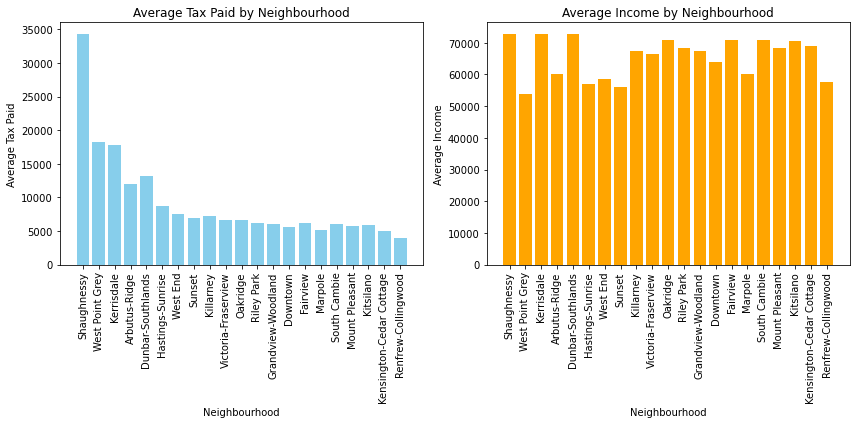

In [23]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(tax_income_pandas_df['neighbourhood'],
        tax_income_pandas_df['avg_tax_paid'],
        color='skyblue')
plt.xlabel('Neighbourhood')
plt.ylabel('Average Tax Paid')
plt.title('Average Tax Paid by Neighbourhood')
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
plt.bar(tax_income_pandas_df['neighbourhood'],
        tax_income_pandas_df['avg_income'],
        color='orange')
plt.xlabel('Neighbourhood')
plt.ylabel('Average Income')
plt.title('Average Income by Neighbourhood')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Graph 4- Showing Affordability of Property based on Neighbourhood

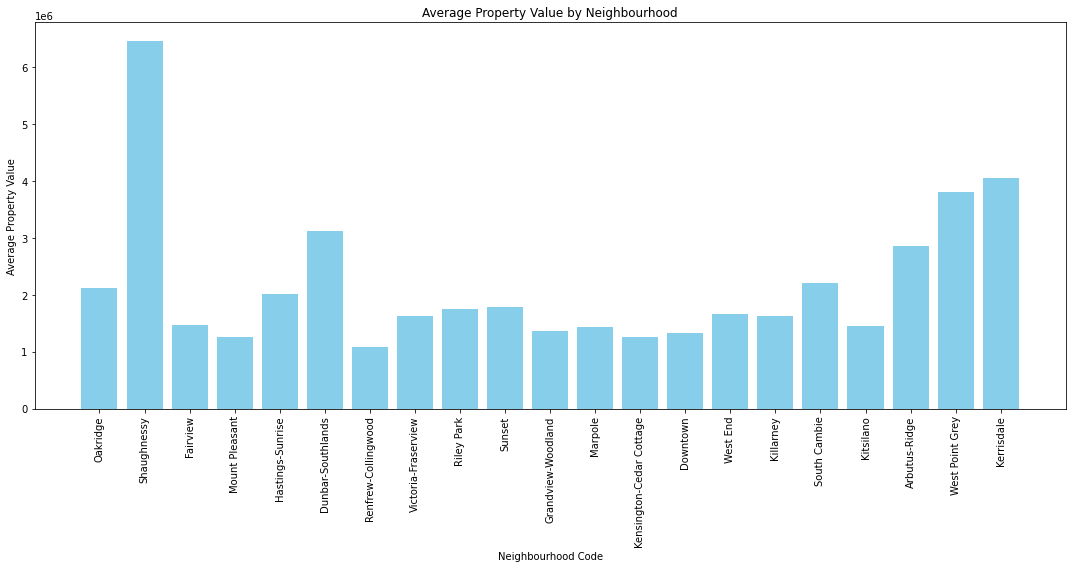

In [24]:
neighborhood_affordability_pandas_df = neighborhood_affordability_df.toPandas()
plt.figure(figsize=(15, 8))
plt.bar(neighborhood_affordability_pandas_df['neighbourhood'],
        neighborhood_affordability_pandas_df['avg_property_value'],
        color='skyblue')
plt.xlabel('Neighbourhood Code')
plt.ylabel('Average Property Value')
plt.title('Average Property Value by Neighbourhood')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

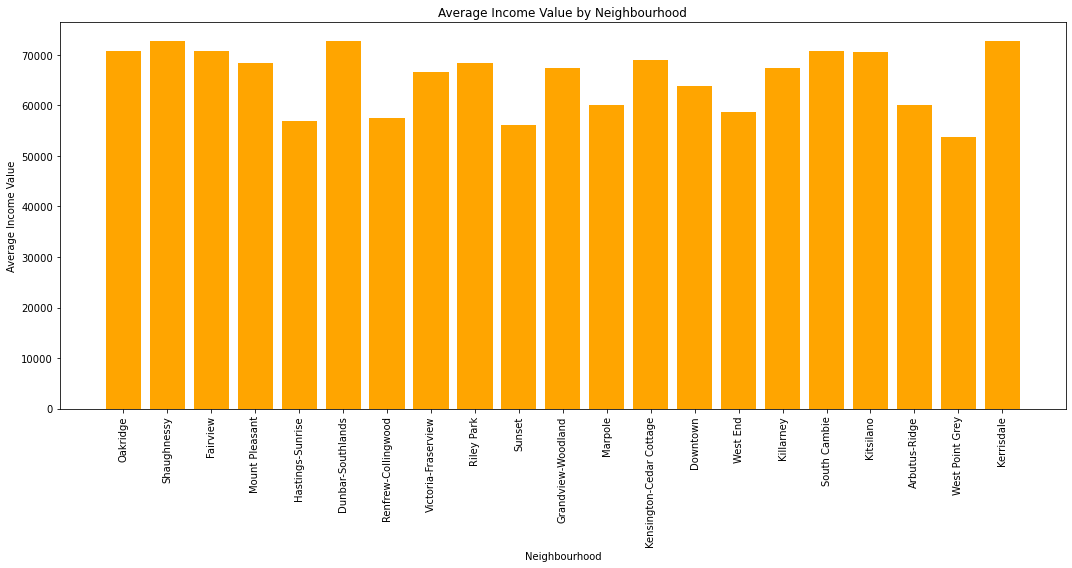

In [25]:
plt.figure(figsize=(15, 8))
plt.bar(neighborhood_affordability_pandas_df['neighbourhood'],
        neighborhood_affordability_pandas_df['avg_income'],
        color='orange')
plt.xlabel('Neighbourhood')
plt.ylabel('Average Income Value')
plt.title('Average Income Value by Neighbourhood')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

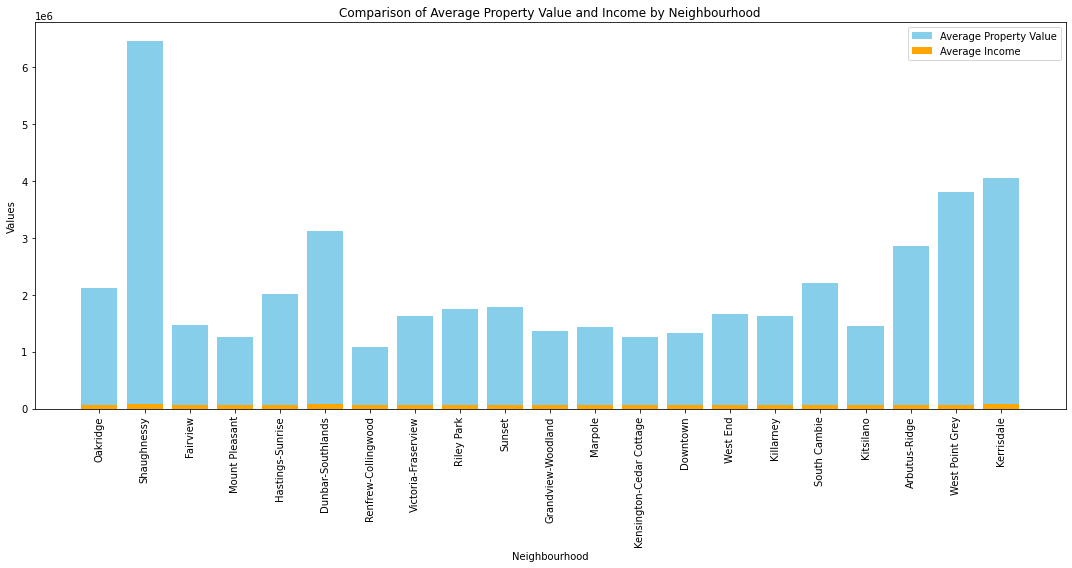

In [26]:
plt.figure(figsize=(15, 8))
plt.bar(neighborhood_affordability_pandas_df['neighbourhood'],
        neighborhood_affordability_pandas_df['avg_property_value'],
        color='skyblue', label='Average Property Value')
plt.bar(neighborhood_affordability_pandas_df['neighbourhood'],
        neighborhood_affordability_pandas_df['avg_income'],
        color='orange', label='Average Income')
plt.xlabel('Neighbourhood')
plt.ylabel('Values')
plt.title('Comparison of Average Property Value and Income by Neighbourhood')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

### Graph 5 - Scatter plot: Property Value vs. Average Income

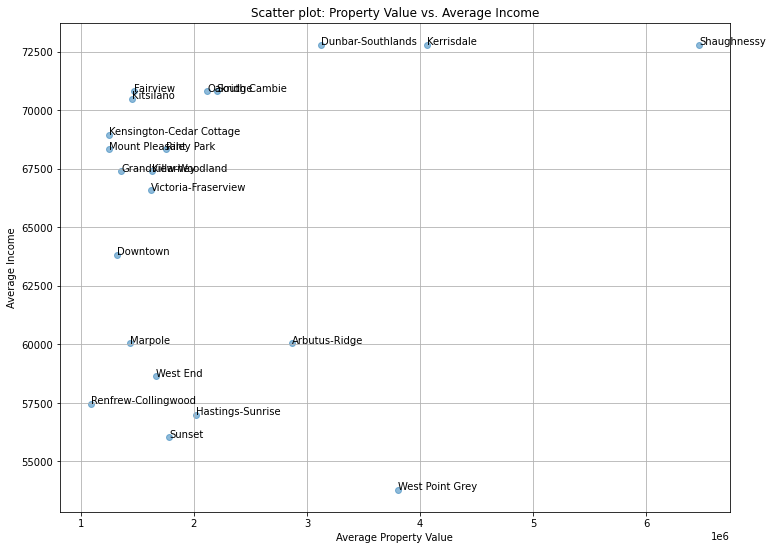

In [27]:
plt.figure(figsize=(12, 9))
plt.scatter(neighborhood_affordability_pandas_df['avg_property_value'], 
            neighborhood_affordability_pandas_df['avg_income'], alpha=0.5)
plt.xlabel('Average Property Value')
plt.ylabel('Average Income')
plt.title('Scatter plot: Property Value vs. Average Income')
num_labels = 10
plt.grid(True)
for i, txt in enumerate(neighborhood_affordability_pandas_df['neighbourhood']):
    plt.annotate(txt, (neighborhood_affordability_pandas_df['avg_property_value'][i], 
                       neighborhood_affordability_pandas_df['avg_income'][i]))
plt.show()

In [28]:
correlation = np.corrcoef(neighborhood_affordability_pandas_df['avg_property_value'],
                          neighborhood_affordability_pandas_df['avg_income'])[0, 1]
print(f"Correlation between Property Value and Average Income: {correlation}")

Correlation between Property Value and Average Income: 0.2128576707067249


### Graph 6 - Showing Property Value with Respect to Land Value over the year 

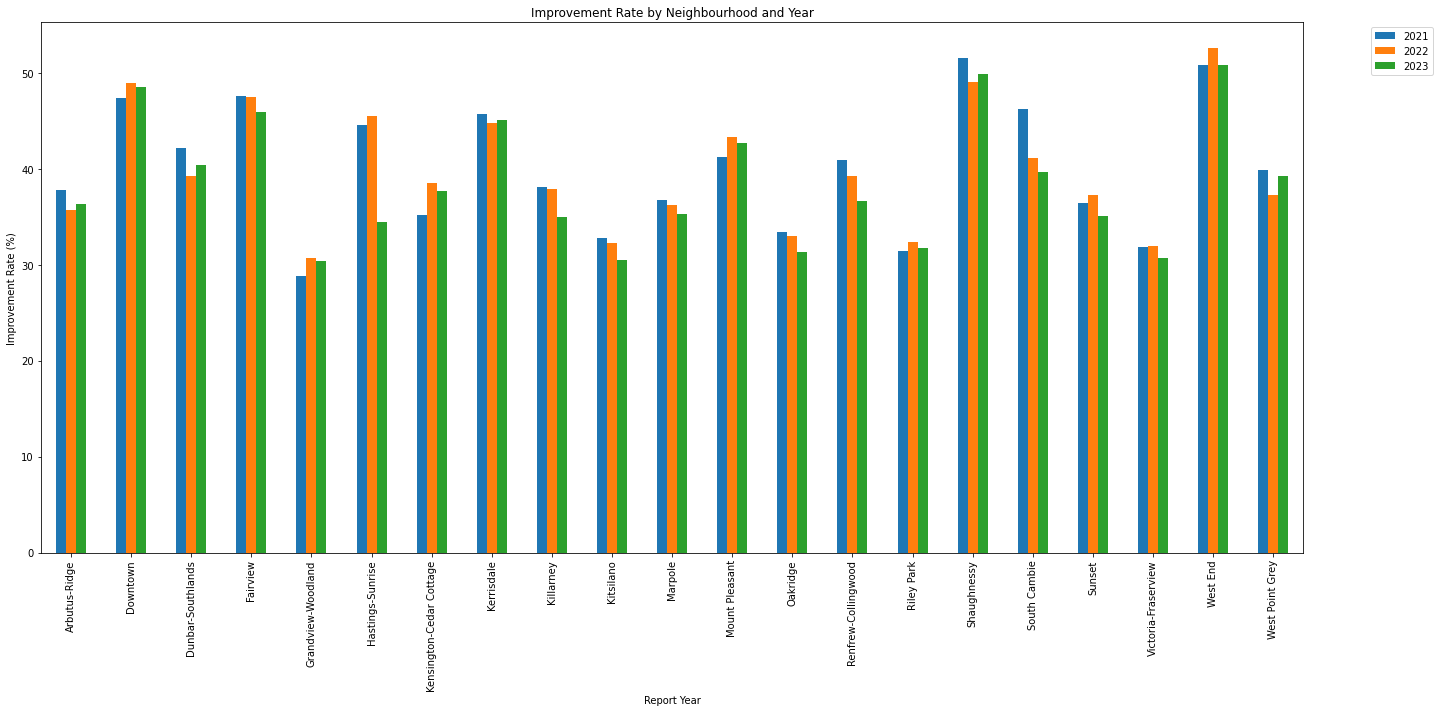

In [29]:
improvement_pandas_df = improvement_neighbourhood_df.toPandas()
pivot_df = improvement_pandas_df.pivot(index='neighbourhood', columns='report_year', values='improvement_ratio')
pivot_df.plot(kind='bar', figsize=(20, 10))
plt.xlabel('Report Year')
plt.ylabel('Improvement Rate (%)')
plt.title('Improvement Rate by Neighbourhood and Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Heat Map : Price to Income Ratio indicating affordability based on Neighbourhood

In [30]:
vancouver_map = folium.Map(location=[49.2827, -123.1207], zoom_start=12)
neighborhoods = {
    'West End': [49.2868, -123.1330],
    'West Point Grey': [49.2646, -123.2029],
    'Marpole': [49.2092, -123.1362],
    'Kerrisdale': [49.2342, -123.1551],
    'Hastings-Sunrise': [49.2817, -123.0401],
    'Downtown': [49.2827, -123.1207],
    'Oakridge': [49.2308, -123.1315],
    'Killarney': [49.2242, -123.0465],
    'Mount Pleasant': [49.2634, -123.0968],
    'Victoria-Fraserview': [49.2181, -123.0706],
    'Kitsilano': [49.2694, -123.1553],
    'Dunbar-Southlands': [49.2535, -123.1852],
    'Renfrew-Collingwood': [49.2426, -123.0405],
    'Kensington-Cedar Cottage': [49.2480, -123.0805],
    'Arbutus-Ridge': [49.2468, -123.1602],
    'Fairview': [49.2641, -123.1338],
    'Grandview-Woodland': [49.2750, -123.0677],
    'Riley Park': [49.2447, -123.1033],
    'Shaughnessy': [49.2517, -123.1386],
    'South Cambie': [49.2468, -123.1216]
}

gradient_colors = {
    0.1: 'blue',
    0.2: 'cyan',
    0.3: 'yellow',
    0.4: 'orange',
    0.5: 'red'
}

In [31]:
price_to_income_pandas = price_to_income_df.toPandas()


neighborhood_coords = pd.DataFrame(neighborhoods.items(), columns=['neighbourhood', 'coords'])
price_to_income_pandas = price_to_income_pandas.merge(neighborhood_coords, how='left', left_on='neighbourhood', right_on='neighbourhood')
price_to_income_pandas.dropna(subset=['coords'], inplace=True)

vancouver_map = folium.Map(location=[49.2827, -123.1207], zoom_start=12)

heat_data = [[row['coords'][0], row['coords'][1], row['price_to_income_ratio']] 
             for index, row in price_to_income_pandas.iterrows()]

for neighborhood, coords in neighborhoods.items():
    folium.Marker(location=coords, popup=neighborhood).add_to(vancouver_map)

HeatMap(heat_data, radius=40, gradient=gradient_colors).add_to(vancouver_map)
vancouver_map

#Save Command to Save Map as HTML 
#vancouver_map.save("Vancouver_Heat_map.html") 


## Machine Learning 
We have created Regression Machine Learning Models to predict price of property, we have used three Algorithms: Linear Regression, Random Forest, and Gradient Boosted Trees. We have done a comparison between the results, using R Squared and RMSE

In [37]:
train, validation = transformed_df.randomSplit([0.75, 0.25])
train = train.cache()
validation = validation.cache()

assembler = VectorAssembler(
    inputCols = ['tax_assessment_year', 'previous_land_value', 'previous_improvement_value', 'year_built', 
                 'big_improvement_year', 'current_improvement_value', 'tax_levy', 'neighbourhood_code', 'report_year'], 
    outputCol = 'feature_vector')

regressors = [
    GBTRegressor(featuresCol='feature_vector', labelCol='current_land_value'),
    RandomForestRegressor(featuresCol='feature_vector', labelCol='current_land_value'),
    LinearRegression(featuresCol='feature_vector', labelCol='current_land_value')]

predictions_df_list = []

In [38]:
for regressor in regressors:
    house_pipeline = Pipeline(stages=[assembler, regressor])
    house_model = house_pipeline.fit(train)
    predictions = house_model.transform(validation)

    r2_evaluator = RegressionEvaluator(
        predictionCol='prediction',
        labelCol='current_land_value',
        metricName='r2')
    r2 = r2_evaluator.evaluate(predictions)

    rmse_evaluator = RegressionEvaluator(
        predictionCol='prediction',
        labelCol='current_land_value',
        metricName='rmse')
    rmse = rmse_evaluator.evaluate(predictions)

    print(f"Regressor: {regressor.__class__.__name__}")
    print('Validation score for R Squared:', r2)
    print('Validation score for RMSE:', rmse)
    print('------------------------------------')
    predictions_df_list.append((regressor.__class__.__name__, predictions))


Regressor: GBTRegressor
Validation score for R Squared: 0.6464308905573026
Validation score for RMSE: 1927024.0187710403
------------------------------------
Regressor: RandomForestRegressor
Validation score for R Squared: 0.48888275795222935
Validation score for RMSE: 2316915.720752721
------------------------------------
Regressor: LinearRegression
Validation score for R Squared: 0.9829473429339529
Validation score for RMSE: 423200.3319406984
------------------------------------


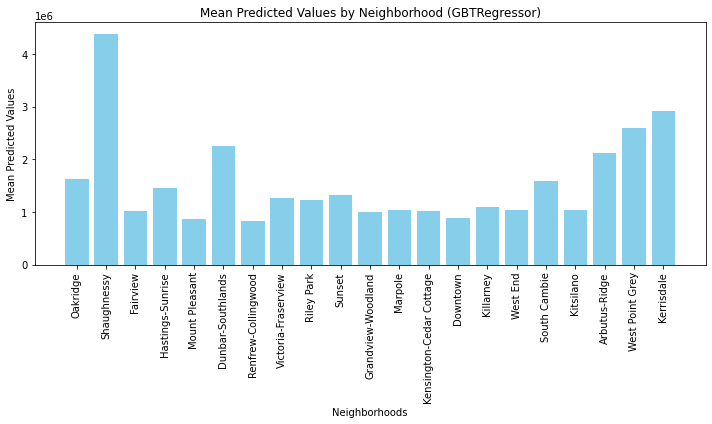

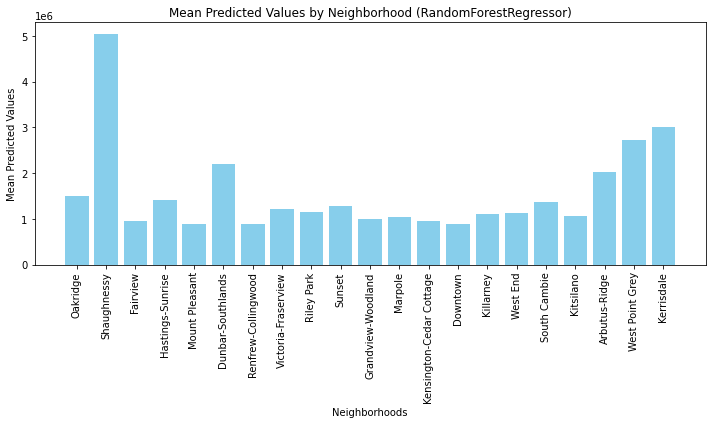

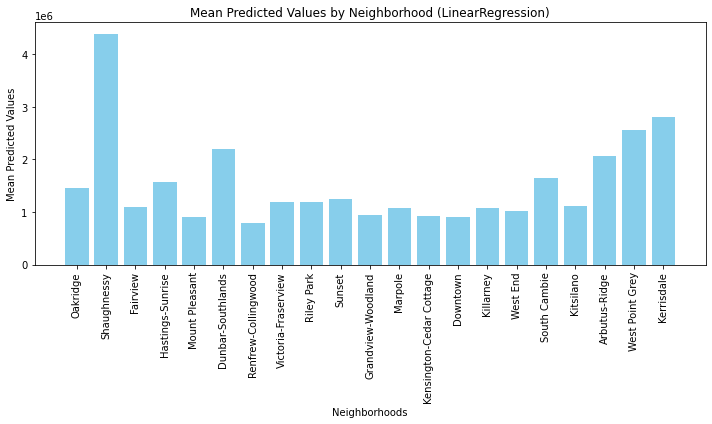

In [34]:
for regressor_name, predictions_df in predictions_df_list:
    neighborhoods = predictions_df.select('neighbourhood').distinct().collect()
    predicted_means = []
    
    for neighborhood in neighborhoods:
        neighborhood_name = neighborhood['neighbourhood']
        neighborhood_predictions = predictions_df.filter(predictions_df['neighbourhood'] == neighborhood_name)
        
        predicted_values = [row['prediction'] for row in neighborhood_predictions.collect()]
        predicted_mean = np.mean(predicted_values)
        predicted_means.append(predicted_mean)
    
    plt.figure(figsize=(10, 6))
    plt.bar([n['neighbourhood'] for n in neighborhoods], predicted_means, color='skyblue')
    plt.xlabel('Neighborhoods')
    plt.ylabel('Mean Predicted Values')
    plt.title(f'Mean Predicted Values by Neighborhood ({regressor_name})')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
